# Enabling quantitative variables in ARM: Test task

## Quick summary (skip if you read the README):

### Pipeline

1. **Load dataset and rules** in a suitable form for further computations;
2. **Make decision on `NaN` containing rows**: skip them only when working with the columns containing such values;
3. **Compile a list of metrics** and their aggregate to evaluate the usefulness of a rule (see heuristics);
4. **Prune** the rules that don't exceed the threshold;
5. **Cluster rules with equal metric values**, leave only the rule or combination (conjunction) of them with the highest evaluation metric;
6. **Cluster highly-correlated rules**, and for each cluster pick the rule or combination (conjunction) of them with the highest evaluation metric;
7. **Make an assumption on the prediction** of a set of rules: $50\%$ majority rule in our case;
8. **Compile a list of metrics** and their aggregate to evaluate the efficiency of a set of rules (see heuristics);
9. **Perform deterministic or probabilistic search** (depending on ruleset size) for the subset that maximized the efficiency;
10. **Prepare the output**.

### Heuristics for Rule Set Compression  

#### [3] Metrics for rule evaluation:
- **Precision**, **recall**, **F1 score**
- **Frequency, length, completeness**
- **p\_value through chi-square test**
- **evaluation**: the weighted aggregate of the metrics above.

A detailed description of each metric can be found in the corresponding section in the notebook.

---

#### [4] Threshhold:
Set using the **1.5 Whiskers box** method for the existing dataset of rules and their metrics.

---

#### [5, 6] Cluster-Based Rule Refinement  

Since many rules may be correlated, we cluster them based on their associated features and refine the rule set within each cluster.  

1. **Cluster rules by feature similarity:**  

   $$ C_i = \{ R_j \mid \text{Feature}(R_j) \in F_i \} $$

   where $C_i$ is a cluster of rules and $F_i$ is a feature group.  

2. **Iterate through each cluster and refine the rule set:**  

   $$ R_{\text{new}} = \text{test\_combinations}(C_i, R_{\text{old}}) $$

3. **Update rule set only when improvements are found:**  

   $$ R =  
   \begin{cases}  
   R_{\text{new}}, & \text{if } S(R_{\text{new}}) > S(R) \\  
   R, & \text{otherwise}  
   \end{cases} $$


##### Hyperparameters:
- Number of clusters

---

#### [8] Evaluation Metrics for Rule Selection  

To guide the optimization, we employ multiple evaluation metrics:  

- **Accuracy**;
- **Detailed Accuracy**;
- **Coverage**;
- **AUC (precision-recall)**;
- **Evaluation:** the weighted aggregate of the metrics above.

A detailed description of each metric can be found in the corresponding section in the notebook.

---


#### [9] Search for the optimal subset of rules

- **Exhaustive Search for Optimal Rule Subset [Deterministic]**

This method performs an exhaustive search over all possible subsets of rules and selects the best one based on an evaluation function. It is only feasible for rule sets of less than 15 rules.  

##### Process:  
1. Iterate over all subsets of rules, starting from size 2 to avoid trivial solutions.  
2. Evaluate each subset using the scoring function:  

   $$ S(R) = \text{evaluate\_ruleset}(R) $$

   where $R$ is a given subset of rules.  
3. Track the best subset $R^*$ with the highest score:  

   $$ R^* = \arg\max_{R \subseteq \mathcal{R}} S(R) $$

---

- **Genetic Algorithm for Rule Optimization [Probabilistic]**

For larger rule sets, we employ a Genetic Algorithm (GA) to find an optimal subset probabilistically.  

##### Process:  
1. **Population Initialization:** Generate an initial population of random subsets, ensuring at least 2 rules per subset.  

2. **Selection:** Compute scores for all subsets and retain the top 50%:  

   $$ P_{\text{selected}} = \text{top}_{50\%} \left( \{ (R, S(R)) \mid R \in P \} \right).$$

3. **Crossover:** Merge two subsets to form a new one and remove duplicate rules:  

   $$ R_{\text{child}} = R_{\text{parent}_1}[1:k] \cup R_{\text{parent}_2}[1:m].$$


4. **Mutation:** With probability $p_{\text{mutate}}$, modify the subset:  
     - Randomly add a new rule.  
     - Remove an existing rule (if the subset contains more than 2 rules).  

5. **Iteration:** Run for $G$ generations, tracking the best subset:  

   $$ R^* = \arg\max_{R \in P_G} S(R) $$

##### Hyperparameters:  
- $N$: Population size.  
- $G$: Number of generations.  
- $p_{\text{mutate}}$: Mutation probability.  

---

These heuristics ensure that the final rule set is **compact**, **accurate**, and **efficient**, balancing performance and interpretability.

### Challenges:

- Lack of practical experience and mentorship;
- Lack of concentration and time due to exams;
- Confusion on the expected complexity of the solution;
- Small amount of test data.

### Flaws of the solution:

- Not a well-connected solution: it feels more like useful (or not) pieces of ideas put together;
- Feels a bit like childish, since I focused on the phrase *"how to decide what's important for rule compression"*. I didn't want to waste much time, since I was not sure this is the direction you would like to see;
- Some metrics feel repetitive and might be correlated to each other.

### Ideas not implemented:

- Use more advanced methods to select better rules;
- Study covariance for 'biomarker' and 'NOT biomarker' separately;
- Refine and test metrics, as now they are just empirical and random;
- Fine-tuning several (hyper)parameters, such as weights in formulas, number of clusters, etc.;
- In general, test and research more for better decision-making.

### Failed ideas

- Semantic and math.logic reductions and equivalent transformations, due to lack of OR operator;
- If the original rule has low-accuracy, replace it by its negation: can't generate for 2+ biomarker rules (lack of OR operator);
- For A and AB, if precA > precAB, then automatically remove AB, since freqA>freqAB. Maybe add A + NOT B, and remove A as well.

## LOADING DATA

### Imports and Libraries

In [29]:
import os
import random
from itertools import combinations
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
# from mlxtend.frequent_patterns import apriori, association_rules
# from mlxtend.preprocessing import TransactionEncoder

We begin by loading the dataset `df` as a pandas DataFrame, containing biomarker data for different samples. Additionally, we define `rules_list`, an array of logical conjunctions of biomarkers and their negations. Different representations of these rules will be used throughout the analysis (see below).

### Dataset of donors and their biomarker predicates

In [3]:
dataset_path = 'data/dataset.tsv'

try:
    df = pd.read_csv(dataset_path, sep='\t', encoding='utf-8')
except FileNotFoundError:
    print(f"Error: {dataset_path} not found.")
except Exception as e:
    print(f"Error loading file: {e}")

df.head()

,donor_is_old,BMI,WBC,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,Neutrophils_percent,Lymphocytes_percent,...,IL_2,IL_4,IL_6,IL_8,TNF_α,sCD86,GDF_15,SOST,OMD,Notch_1
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
1,False,True,False,False,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
2,False,True,True,True,True,False,False,False,False,False,...,True,True,True,False,True,False,False,False,NaN,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,True,True,False,...,False,False,True,True,False,False,False,False,False,False


In [30]:
df.describe()

,donor_is_old,BMI,WBC,Neutrophils,Lymphocytes,Monocytes,Eosinophils,Basophils,Neutrophils_percent,Lymphocytes_percent,...,IL_2,IL_4,IL_6,IL_8,TNF_α,sCD86,GDF_15,SOST,OMD,Notch_1
count,39,39,39,36,39,39,36,39,35,39,...,39,39,39,39,39,39,38,38,37,37
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
freq,20,28,29,27,29,29,27,26,26,29,...,29,29,39,29,29,29,28,28,27,27


In [5]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_values.to_frame(name="NaN Count")

,NaN Count
Neutrophils_percent,4
Eosinophils_percent,4
Neutrophils,3
Eosinophils,3
OMD,2
Notch_1,2
GDF_15,1
SOST,1


We observe that `NaN` values are present in only a few columns. Since their occurrence is limited and class distribution remains balanced, we opt to **ignore missing values during computations involving those columns rather than applying imputation or row deletion**. This approach ensures minimal data loss while maintaining dataset integrity.

In [6]:
old_donors = df[df['donor_is_old'] == True]

num_old_donors = len(old_donors)
percentage_old_donors = (num_old_donors / len(df) * 100) if len(df) > 0 else 0

print(f"Number of old donors: {num_old_donors}")
print(f"Percentage of old donors: {percentage_old_donors:.3f}%")

Number of old donors: 20
Percentage of old donors: 51.282%


### Rules

We will work with rules in three different formats, depending on the task:

- **String format**: `'NOT Basophils_percent AND IL_12p70'`  
  A human-readable representation using logical operators. Mainly used, when the rule needs no processing.

- **List format**: `['NOT Basophils_percent', 'IL_12p70']`  
  A more structured format that represents individual conditions as list elements. Only used to get all possible rule combinations (see section on group filtering).

- **Dictionary format**: `{'Basophils_percent': False, 'IL_12p70': True}`  
  A key-value format, where the key is the biomarker, and the value indicates whether the biomarker is part of the rule (`True`) or its negation (`False`). Widely used each time we require rule processing and evaluation.

In [7]:
file_path = 'data/rules.txt'

if os.path.exists(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            rules = [line.strip() for line in file if line.strip()]
        print(f"Loaded {len(rules)} rules.")
    except Exception as e:
        print(f"Error reading file: {e}")
else:
    print(f"File 'rules.txt' not found at {file_path}.")

Loaded 51 rules.


Below, we implement three simple functions to convert a rule to the needed format: dictionary, string, or list.

In [8]:
def rule_to_dict(rule: str) -> dict:
    conditions = [condition.strip() for condition in rule.split("AND")]
    rule_dict = {}

    for condition in conditions:
        if condition.startswith("NOT "):
            rule_dict[condition[4:].strip()] = False
        else:
            rule_dict[condition.strip()] = True

    return rule_dict

def rule_to_str(rule: dict) -> str:
    return ' AND '.join([f"NOT {key}" if value is False else key for key, value in rule.items()])

def rule_to_list(rule: dict) -> list:
    return [f"NOT {key}" if value is False else key for key, value in rule.items()]

We create a list of all the uploaded rules in dict format, ensuring that all duplicated rules or predicates are removed.

In [9]:
rules_set = set()

for rule in rules:
    lhs = rule.split('=>')[0].strip()
    conditions = {condition.strip() for condition in lhs.split('AND')}
    rules_set.add(frozenset(conditions))

rules_list = [{condition.split(' ')[-1]: False if 'NOT' in condition else True
               for condition in sorted(list(rule))} for rule in rules_set]

rules_list[:5]

[{'Hb': False, 'IL_12p70': False},
 {'Monocytes_percent': True},
 {'Lymphocytes_percent': False, 'Notch_1': False},
 {'IL_13': True},
 {'Hb': False, 'IL_2': False}]

### Dataset of rules

It may be a good idea later to create a **dataset with rules as columns** rather than separate biomarkers. This dataset could be useful for studying the covariance of the rules and other characteristics of potential optimal rule sets. This dataset will contain two additional columns:

- `Majority_True`: a boolean column that equals `True` if at least $50\%$ of the rules are satisfied, and `False` otherwise.
- `True_Count`: a counter of the total of rules that are satisfied by the row (donor). 

In [10]:
def add_column(dfr, rule: dict):
    conditions = [
        df[column] == value for column, value in rule.items()
    ]

    dfr[rule_to_str(rule)] = conditions[0]
    for condition in conditions[1:]:
        dfr[rule_to_str(rule)] &= condition

def df_of_rules(df, rules_list: list[dict]):
    df_rules = df[['donor_is_old']].copy()

    for rule in rules_list:
        add_column(df_rules, rule)

    df_rules["Majority_True"] = df_rules.iloc[:, 1:].mean(axis=1) >= 0.8
    df_rules["True_count"] = df_rules.iloc[:, 1:-1].sum(axis=1)

    return df_rules

df_of_rules(df, rules_list).tail()

,donor_is_old,NOT Hb AND NOT IL_12p70,Monocytes_percent,NOT Lymphocytes_percent AND NOT Notch_1,IL_13,NOT Hb AND NOT IL_2,NOT Lymphocytes_percent,NOT Notch_1 AND NOT RBC,Eosinophils,NOT Hb AND NOT Lymphocytes_percent,...,NOT Notch_1,Eosinophils_percent,NOT Basophils_percent,NOT IL_2,SOST,NOT Basophils_percent AND NOT Notch_1,OMD,NOT Hb AND NOT IL_10,Majority_True,True_count
34,True,True,True,True,False,True,True,False,False,True,...,True,True,True,True,False,True,False,True,False,33
35,True,False,False,False,True,False,True,False,False,True,...,False,False,True,False,True,False,False,False,False,18
36,True,True,True,True,False,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,41
37,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,False,True,False,True,False,40
38,True,True,False,True,False,True,True,True,False,True,...,True,True,True,True,True,True,False,True,False,38


## PREPARING METRICS FOR RULE EVALUATION

Below, we introduce several metrics that will help evaluate the usefulness of a rule. These metrics will later be used to compare and filter out rules during decision-making and rule compression.

It is important to keep in mind that we define four types of (non)errors:

- **True Positives (TP)**: Donors that satisfy the rule and are indeed old.
- **False Positives (FP)**: Donors that satisfy the rule but are not old.
- **False Negatives (FN)**: Donors that do not satisfy the rule but are old.
- **True Negatives (TN)**: Donors that do not satisfy the rule and are not old.

⚠️ Note: The TN category is mostly **ignored**, as the rule does not define an inverse implication. This means we do not explicitly consider cases where a rule is not satisfied, unless the donor is old.

### Metrics for rules

<img src="images/metric_rank.jpg" width="80%" height="100%">

About **f1** calculation: $$prec = \frac{TP}{TP + FP}, \quad\quad recall = \frac{TP}{TP + FN}, \quad\quad f1 = 2\cdot\frac{prec \cdot recall}{prec + recall}.$$

About **completeness**: $$spec = \#\text{biomarkers}, \quad\quad freq = \frac{TP + FP}{\#\text{donors}}, \quad\quad compl = freq + \frac{1}{10}\min\{spec, \text{MAX\_LEN}\}, \quad \text{where\, MAX\_LEN} = 6.$$
*Hyperparameters*: MAX\_LEN -- the number of biomarkers or their negation in the rule.

Intermediate formulas in **chi-square test**: $$\chi^2 = \sum \frac{(O - E)^2}{E}, \quad\quad E = \frac{(\text{Row Total} \times \text{Column Total})}{\text{Grand Total}}, \quad\quad df = (\text{rows} - 1) \times (\text{columns} - 1).
$$

The aggregation formula for **evaluation**: $$\boxed{\text{eval} = w_1 \cdot \text{f1} + w_2\cdot \text{freq} + w_3\cdot (1 - \text{pval}),}\quad \text{where by default } \,w_1=4,\, w_2=2,\, w_3=4.$$
*Parameters*: $w_1, w_2, w_3$.

### Dataset of rules and their metric values

In [11]:
class RuleEvaluator:
    def __init__(self, rule: dict, df: pd.DataFrame):
        self.rule = rule
        self.df = df

    @property
    def n_old_donors(self):
        return len(self.df[self.df['donor_is_old']])

    def rule_filter(self):
        """Returns all rows that satisfy the rule and, 
        among them, all donors that are indeed old."""
        filter_conditions = [(df[col] == val) for col, val in self.rule.items()]
        if not filter_conditions:
            return df.copy(), df[df['donor_is_old']].copy()  # Edge case: empty rule

        rule_donors = df[np.logical_and.reduce(filter_conditions)]
        rule_old_donors = rule_donors[rule_donors['donor_is_old']].copy()

        return rule_donors, rule_old_donors

    def precision(self):
        """Calculates precision: TP / (TP + FP)"""
        rule_donors, rule_old_donors = self.rule_filter()
        return round(len(rule_old_donors) / len(rule_donors), 2) if len(rule_donors) else 0

    def recall(self):
        """Calculates recall: TP / (TP + FN)"""
        return round(len(self.rule_filter()[1]) / self.n_old_donors, 2)

    def f1(self):
        """Computes the F1-score as a trade-off between precision and recall"""
        p, r = self.precision(), self.recall()
        return round(2 * (p * r) / (p + r), 3) if (p + r) else 0

    def frequency(self):
        """Calculates the frequency: portion of all data that satisfies the rule"""
        return round(len(self.rule_filter()[0]) / len(self.df), 2)

    def specificness(self):
        """Returns the number of biomarkers in the rule"""
        return len(self.rule)

    def completeness(self):
        """Custom metric combining frequency and rule length"""
        MAX_RULE_LENGTH = 6  # Define maximum desired rule length
        return round(self.frequency() + min(MAX_RULE_LENGTH / 10, self.specificness() / 10), 3)

    def lift(self):
        """Calculates lift: the ratio of precision to the probability of randomly selecting an old donor"""
        return round(self.precision() / (self.n_old_donors / len(self.df)), 2)

    def chi_square_test(self):
        """Performs a Chi-Square test to evaluate the relationship between a rule's conditions and being an old donor."""
        conditions = [(df[predicate] == value) for predicate, value in self.rule.items()]
        mask = np.logical_and.reduce(conditions) if conditions else np.ones(len(df), dtype=bool)

        contingency_table = pd.crosstab(mask, df['donor_is_old'])

        if contingency_table.shape != (2, 2):
            return 1.0

        _, p_value, _, _ = chi2_contingency(contingency_table)

        return round(p_value, 4)

    def evaluation(self, wf1=4, wfreq=2, wchi=4, drop_length=True):
        """Evaluates a rule based on a weighted sum of F1-score, frequency, and Chi-Square test result.

        Args:
            df (pd.DataFrame): The dataset.
            rule (dict): The rule in dictionary format.
            wf1 (int, optional): Weight for F1-score. Defaults to 4.
            wfreq (int, optional): Weight for frequency. Defaults to 2.
            wchi (int, optional): Weight for Chi-Square test. Defaults to 4.
            drop_length (bool, optional): If True, uses frequency; otherwise, uses completeness.

        Returns:
            float: The evaluation score.
        """
        weight_freq = self.frequency() if drop_length else self.completeness()
        chi_score = 1 - self.chi_square_test()

        return round(wf1 * self.f1() + wfreq * weight_freq + wchi * chi_score, 4)

    def add_rule(self):
        """Computes various metrics for a given rule.

        Returns:
            dict: Dictionary containing rule metrics.
        """
        return {
            "rule": rule_to_str(self.rule),
            "prec": self.precision(),
            "recall": self.recall(),
            "f1": self.f1(),
            "freq": self.frequency(),
            "spec": self.specificness(),
            "compl": self.completeness(),
            "lift": self.lift(),
            "pval": self.chi_square_test(),
            "eval": self.evaluation()
        }

In [12]:
# Compute rule metrics for every rule and store as dict
rule_metrics = [RuleEvaluator(rule, df).add_rule() for rule in rules_list]

So, an entry of the list `rule_metrics` looks like this: 

In [13]:
rule_metrics[0]

{'rule': 'NOT Hb AND NOT IL_12p70',
 'prec': 0.65,
 'recall': 0.65,
 'f1': 0.65,
 'freq': 0.51,
 'spec': 2,
 'compl': 0.71,
 'lift': 1.27,
 'pval': 0.1504,
 'eval': 7.0184}

Let's present this list as a DataFrame and sort it by the total metric `evaluation` to have a better understanding:

In [14]:
pd.DataFrame(rule_metrics).sort_values(by='eval', ascending=False).head(10)

,rule,prec,recall,f1,freq,spec,compl,lift,pval,eval
5,NOT Lymphocytes_percent,0.62,0.90,0.734,0.74,1,0.84,1.21,0.0538,8.2008
11,NOT Lymphocytes,0.62,0.90,0.734,0.74,1,0.84,1.21,0.0538,8.2008
2,NOT Lymphocytes_percent AND NOT Notch_1,0.76,0.80,0.779,0.54,2,0.74,1.48,0.0024,8.1864
38,NOT Hb AND NOT Lymphocytes,0.76,0.80,0.779,0.54,2,0.74,1.48,0.0024,8.1864
37,NOT Lymphocytes AND NOT Notch_1,0.73,0.80,0.763,0.56,2,0.76,1.42,0.0064,8.1464
8,NOT Hb AND NOT Lymphocytes_percent,0.73,0.80,0.763,0.56,2,0.76,1.42,0.0064,8.1464
9,NOT Hb AND NOT Lymphocytes AND NOT Notch_1,0.88,0.75,0.810,0.44,3,0.74,1.72,0.0002,8.1192
19,NOT Hb AND NOT Notch_1,0.75,0.75,0.750,0.51,2,0.71,1.46,0.0065,7.9940
17,NOT Lymphocytes AND NOT sCD86,0.71,0.75,0.729,0.54,2,0.74,1.38,0.0165,7.9300
42,NOT HCT AND NOT Lymphocytes AND NOT Notch_1,0.93,0.65,0.765,0.36,3,0.66,1.81,0.0004,7.7784


We observe that some rules have **low evaluations and other metrics**, while others have **identical metrics**. To address these issues, we will implement two approaches:

1. **Threshold Filters**:
   - We will apply filters based on specific metric thresholds to eliminate underperforming rules.
3. **Clustering Highly Correlated Rules**:
   - We will identify clusters of highly correlated rules and select the combination with the highest evaluation score.

## COMPRESSING THE SET OF RULES ON A RULE BASIS

To prevent confusion and avoid unnecessary memory allocation, we will use a single variable, `updated_rule_metrics`, to store the most recent version of the ruleset along with the corresponding rule metrics. This variable will be continuously updated as we apply modifications.

### Filtering out Low-Performing Rules

Our strategy is to eliminate **overly specific** rules (those with low coverage of the dataset), **non-informative** rules (those with precision similar to a random classifier), or **poorly-performing** rules, using thresholds determined by the `1.5 Cat Whiskers plot`. While this may not be the most optimal method for setting thresholds, it will serve the purpose for now.

It's important to note that, in our small dataset, the filters do not remove a significant number of 'useless' rules. However, in larger datasets, these filters tend to be more effective (though this also depends on the specific dataset).



In [15]:
# using the 1.5 IQR Whiskers to set thresholds for poorly performing rules
def threshold(metrics, low_bound=True):
    metrics_sorted = np.sort(metrics)

    Q1 = np.percentile(metrics_sorted, 25)
    Q3 = np.percentile(metrics_sorted, 75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    threshold = lower_bound if low_bound else upper_bound
    return threshold

In [16]:
def filter_rules_by_metric(metric_name, rule_metrics=rule_metrics, threshold_func=threshold, low_bound=True):
    """
    Filters rules based on a given metric and threshold function.

    Parameters:
    - metric_name (str): The name of the metric to filter by (e.g., 'pval', 'freq').
    - rule_metrics (list): A list of dictionaries where each dictionary represents a rule and its metrics.
    - threshold_func (function): The function to calculate the threshold (e.g., IQR).
    - low_bound (bool): If True, filter rules that are below the threshold. If False, filter rules above the threshold.

    Returns:
    - list: The rules that don't pass the threshold based on the given metric.
    """

    print(f"Selecting rules with {metric_name} {'lower' if low_bound else 'higher'} than the threshold:")

    metric_values = [rule[metric_name] for rule in rule_metrics]
    threshold_value = threshold_func(metric_values, low_bound)
    print("Threshold =", threshold_value)

    if low_bound:
        filtered_rules = [
            rule['rule'] for rule in rule_metrics 
            if (rule[metric_name] < threshold_value)
        ]
    else:
        filtered_rules = [
            rule['rule'] for rule in rule_metrics 
            if (rule[metric_name] > threshold_value)
        ]

    return filtered_rules

In [17]:
high_pval = filter_rules_by_metric('pval', low_bound=False)
print("Removed rules:", high_pval)

Selecting rules with pval higher than the threshold:
Threshold = 0.598325
Removed rules: ['IL_10', 'NOT IFN_γ', 'NOT Basophils_percent AND NOT IL_12p70', 'NOT Basophils_percent', 'NOT IL_2']


In [18]:
low_f1 = filter_rules_by_metric('f1')
print("Removed rules:", low_f1)

Selecting rules with f1 lower than the threshold:
Threshold = 0.30625
Removed rules: []


In [19]:
low_freq = filter_rules_by_metric('freq')
print("Removed rules:", low_freq)

Selecting rules with freq lower than the threshold:
Threshold = -0.19000000000000006
Removed rules: []


The goal of this function is to **remove rules** that do not meet the selection criteria. We will filter out useless rules that are present in one or more of the provided lists.

In [20]:
# return the list with only rules that meet selection criteria
def remove_rules(all_rules: list[dict], *useless: list[list]) -> list[dict]:
    to_remove = {tuple(bio) for rule in useless for bio in rule}

    return [rule for rule in all_rules if tuple(rule['rule']) not in to_remove]

Here we declare **the most important variable** that will be updated during every step of filtering or compression, namely `updated_rule_metrics`. It will contain only the rules that pass each of the selection processes.

In [26]:
updated_rule_metrics = remove_rules(rule_metrics, high_pval, low_f1, low_freq)
print(f"Threshold filtering removed {len(rule_metrics) - len(updated_rule_metrics)} rules.")
print(f"Now the dataset contains {len(updated_rule_metrics)} rules.")

updated_rule_metrics

Threshold filtering removed 5 rules.
Now the dataset contains 46 rules.


[{'rule': 'NOT Hb AND NOT IL_12p70',
  'prec': 0.65,
  'recall': 0.65,
  'f1': 0.65,
  'freq': 0.51,
  'spec': 2,
  'compl': 0.71,
  'lift': 1.27,
  'pval': 0.1504,
  'eval': 7.0184},
 {'rule': 'Monocytes_percent',
  'prec': 0.8,
  'recall': 0.4,
  'f1': 0.533,
  'freq': 0.26,
  'spec': 1,
  'compl': 0.36,
  'lift': 1.56,
  'pval': 0.0818,
  'eval': 6.3248},
 {'rule': 'NOT Lymphocytes_percent AND NOT Notch_1',
  'prec': 0.76,
  'recall': 0.8,
  'f1': 0.779,
  'freq': 0.54,
  'spec': 2,
  'compl': 0.74,
  'lift': 1.48,
  'pval': 0.0024,
  'eval': 8.1864},
 {'rule': 'IL_13',
  'prec': 0.7,
  'recall': 0.35,
  'f1': 0.467,
  'freq': 0.26,
  'spec': 1,
  'compl': 0.36,
  'lift': 1.36,
  'pval': 0.3142,
  'eval': 5.1312},
 {'rule': 'NOT Hb AND NOT IL_2',
  'prec': 0.7,
  'recall': 0.7,
  'f1': 0.7,
  'freq': 0.51,
  'spec': 2,
  'compl': 0.71,
  'lift': 1.36,
  'pval': 0.0376,
  'eval': 7.6696},
 {'rule': 'NOT Lymphocytes_percent',
  'prec': 0.62,
  'recall': 0.9,
  'f1': 0.734,
  'freq': 0

In [65]:
len(rule_metrics)

51

Let's check the remaining most poor-performing rules after threshold filtering.

In [22]:
pd.DataFrame(updated_rule_metrics).sort_values(by='eval', ascending=False).tail(5)

,rule,prec,recall,f1,freq,spec,compl,lift,pval,eval
17,Monocytes,0.70,0.35,0.467,0.26,1,0.36,1.36,0.3142,5.1312
30,WBC,0.70,0.35,0.467,0.26,1,0.36,1.36,0.3142,5.1312
37,TNF_α,0.70,0.35,0.467,0.26,1,0.36,1.36,0.3142,5.1312
5,Basophils,0.62,0.40,0.486,0.33,1,0.43,1.21,0.5712,4.3192
15,Eosinophils,0.67,0.30,0.414,0.23,1,0.33,1.31,0.5012,4.1112


### More Compression Methods

Below, we explore several non-trivial compression methods, each discussed in its own subsection.

#### Best combo for equally performing rules

As we observed earlier, several rules have **identical metric values**. This could be due to high correlation or other factors (?). To prevent these functionally-identical rules from interfering with the natural covariance of the rest of the rules, we perform this step independently of the clustering step (see below). In any case, keeping all of them would be redundant, so we implement a simple function that retains only the most valuable rule.

Note: we do more than that, actually. We explore **all possible combinations of these rules** and select the combination that yields the highest evaluation metric.

In [23]:
def generate_rule_combinations(rules: list[str]) -> list[str]:
    """Generates a list with all possible combinations of rules in string form."""
    all_combinations = set()  # to remove duplicates

    for r in range(1, len(rules) + 1):
        for subset in combinations(rules, r):
            merged_combined_string = " AND ".join(subset)
            all_combinations.add(merged_combined_string)

    return sorted(all_combinations)

def test_combinations(rule_cluster: list[str], 
                      new_rule_metrics=updated_rule_metrics, 
                      freq_bound=0.25, f1_bound=0.3, pval_bound=0.6
                     ) -> list[dict]:
    """
    Evaluates combinations of rules in a cluster, keeping the best one based on evaluation metrics 
    and removing all the previously existing ones in the cluster.

    Parameters:
    - rule_cluster (list of str): List of individual rules to generate combinations from.
    - updated_rule_metrics (list of dict): Current list of rule metrics to be updated.
    - f1_bound (float): Minimum acceptable F1 score for a rule to be considered.
    - pval_bound (float): Maximum acceptable p-value for the rule to be considered.

    Returns:
    - list of dict: Updated list of rule metrics, including the best rule.
    """

    # Generate all rule combinations from the cluster
    rule_combos = generate_rule_combinations(rule_cluster)

    # Remove any existing rules that are present in the combinations (based on their rule name)
    new_rule_metrics = [
        rule_data for rule_data in new_rule_metrics if rule_data['rule'] not in rule_combos
    ]

    evaluated_rules = []

    # Evaluate each combination
    for combo in rule_combos:
        new_rule = rule_to_dict(combo)
        rule_m = RuleEvaluator(new_rule, df)

        # Check if the new rule passes the minimal requirements
        if rule_m.frequency() > freq_bound and rule_m.f1() > f1_bound and rule_m.chi_square_test() < pval_bound:
            evaluated_rules.append((new_rule, rule_m.evaluation()))  # Add valid rule and its evaluation score

    # Handle the case where no valid evaluated rules are found
    if not evaluated_rules:
        print("No valid rule combinations found.")
        return new_rule_metrics  # No need to add a new best rule

    evaluated_rules.sort(key=lambda x: x[1], reverse=True)
    best_rule, best_evaluation = evaluated_rules[0]

    # Add the best rule to the updated rule metrics
    new_rule_metrics.append(RuleEvaluator(best_rule, df).add_rule())
    print("Best new rule:", rule_to_str(best_rule))  # Output the best rule found

    return new_rule_metrics

In [24]:
grouped_rules = defaultdict(list)

# grouping rules with equal metrics
for rule_data in updated_rule_metrics:
    metric_values = tuple(v for k, v in rule_data.items() if k != 'rule')
    grouped_rules[metric_values].append(rule_data['rule'])

for rule_cluster in list(grouped_rules.values()):
    if len(rule_cluster) > 1:
        print(f"Processing rule cluster: {rule_cluster}")
        updated_rule_metrics = test_combinations(rule_cluster, updated_rule_metrics)

Processing rule cluster: ['NOT Lymphocytes_percent', 'NOT Lymphocytes']
Best new rule: NOT Lymphocytes_percent AND NOT Lymphocytes
Processing rule cluster: ['NOT RBC', 'NOT sCD86', 'NOT HCT']
Best new rule: NOT RBC AND NOT HCT
Processing rule cluster: ['NOT IFN_γ AND NOT Lymphocytes', 'NOT IL_2 AND NOT Lymphocytes']
Best new rule: NOT IFN_γ AND NOT Lymphocytes
Processing rule cluster: ['IL_1β', 'Monocytes_percent', 'IL_8', 'OMD']
Best new rule: IL_1β
Processing rule cluster: ['NOT IL_10 AND NOT Lymphocytes', 'NOT IL_12p70 AND NOT Lymphocytes']
Best new rule: NOT IL_10 AND NOT Lymphocytes
Processing rule cluster: ['NOT Hb AND NOT Lymphocytes_percent', 'NOT Lymphocytes AND NOT Notch_1']
Best new rule: NOT Hb AND NOT Lymphocytes_percent AND NOT Lymphocytes AND NOT Notch_1
Processing rule cluster: ['NOT Hb AND NOT IL_2', 'NOT Hb AND NOT IFN_γ', 'NOT Notch_1 AND NOT RBC']
Best new rule: NOT Hb AND NOT IFN_γ
Processing rule cluster: ['NOT HCT AND NOT Monocytes AND NOT Notch_1', 'NOT Hb AND N

In [25]:
print("Num of rules after removing same metric rules:", len(pd.DataFrame(updated_rule_metrics).sort_values(by='eval', ascending=False)))

Num of rules after removing same metric rules: 29


Let's take a look at the dataset with rules as columns to get a general idea.

In [27]:
df_of_rules(df, [rule_to_dict(rule['rule']) for rule in updated_rule_metrics]).tail()

,donor_is_old,NOT Notch_1,Basophils,NOT Basophils AND NOT Lymphocytes AND NOT Notch_1,NOT IL_4 AND NOT Lymphocytes,NOT HCT AND NOT Notch_1,SOST,NOT Hb AND NOT Lymphocytes AND NOT Notch_1,Eosinophils,Neutrophils,...,IL_1β,NOT IL_10 AND NOT Lymphocytes,NOT Hb AND NOT Lymphocytes_percent AND NOT Lymphocytes AND NOT Notch_1,NOT Hb AND NOT IFN_γ,NOT HCT AND NOT Monocytes AND NOT Notch_1 AND NOT Hb,IL_13,NOT Hb AND NOT Lymphocytes,NOT Hb AND NOT IL_10,Majority_True,True_count
34,True,True,True,False,True,False,False,True,False,False,...,False,True,True,True,False,False,True,True,False,18
35,True,False,False,False,False,False,True,False,False,True,...,True,False,False,False,False,True,True,False,False,10
36,True,True,False,True,True,True,True,True,False,False,...,True,True,True,True,True,False,True,True,False,23
37,True,True,False,True,True,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,24
38,True,True,False,True,False,True,True,True,False,False,...,True,True,True,True,True,False,True,True,False,23


#### Clustering highly correlated groups of rules

The goal is to create **clusters of highly correlated rules** and **select the best-performing rule from each cluster**. Correlation is determined based on the dataset of rules: if different rules predominantly apply to the same donors, they are considered highly correlated.

To achieve this, we use **Hierarchical Clustering**, with the number of clusters determined using the **Elbow Method**, provided a predefined threshold is met. This ensures that we retain only the most informative and distinct rules while reducing redundancy. Check the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) for more details.

C:\Users\User\AppData\Local\Temp\ipykernel_8492\2985688315.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


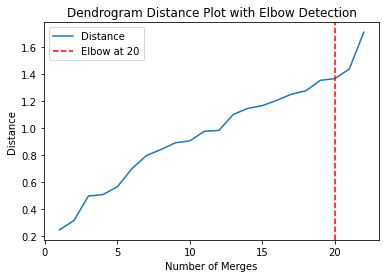

Optimal number of clusters: 20


In [28]:
dfr = df_of_rules(df, [rule_to_dict(rule['rule']) for rule in updated_rule_metrics])
df_numeric = dfr.drop(columns=['donor_is_old', 'Majority_True', 'True_count'])

# Compute correlation and distance matrices
correlation_matrix = df_numeric.corr()
distance_matrix = 1 - abs(correlation_matrix)

# Ensure a valid distance matrix
np.fill_diagonal(distance_matrix.values, 0)

# Perform hierarchical clustering
Z = linkage(distance_matrix, method='ward')

# Extract distances from clustering linkage matrix
distances = Z[:, 2]

# Set a maximum number of clusters
max_clusters = int(len(updated_rule_metrics) - len(updated_rule_metrics) / 5)
distances = distances[:max_clusters - 1]

# Compute first and second derivatives
first_derivative = np.diff(distances)
second_derivative = np.diff(first_derivative)

# Find elbow index
elbow_index = np.argmax(second_derivative) + 1

# Plot results
plt.plot(range(1, len(distances) + 1), distances, label='Distance')
plt.axvline(x=elbow_index, color='r', linestyle='--', label=f"Elbow at {elbow_index}")
plt.xlabel('Number of Merges')
plt.ylabel('Distance')
plt.title('Dendrogram Distance Plot with Elbow Detection')
plt.legend()
plt.show()

print(f"Optimal number of clusters: {elbow_index}")

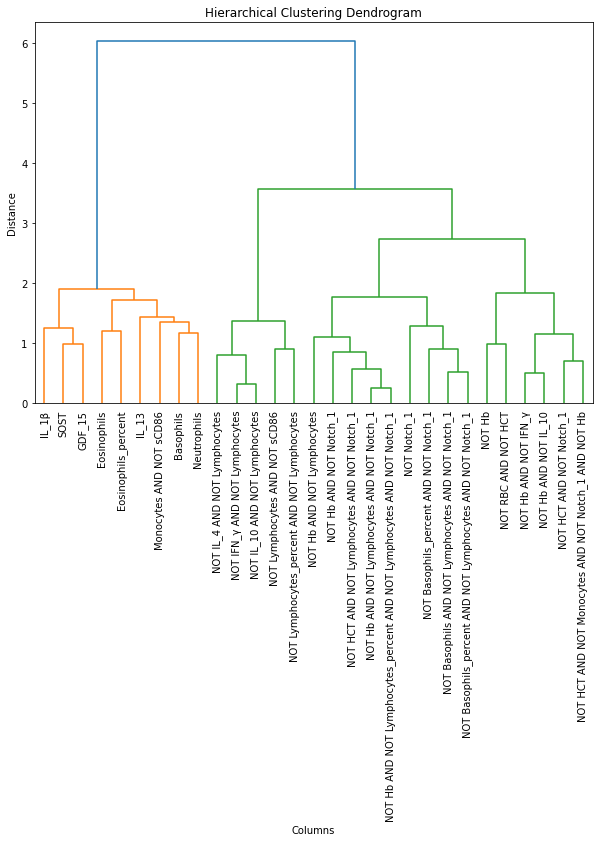

Cluster 1: ['SOST']
Cluster 2: ['GDF_15']
Cluster 3: ['IL_1β']
Cluster 4: ['Eosinophils']
Cluster 5: ['Eosinophils_percent']
Cluster 6: ['Basophils']
Cluster 7: ['Neutrophils']
Cluster 8: ['Monocytes AND NOT sCD86']
Cluster 9: ['IL_13']
Cluster 10: ['NOT IL_4 AND NOT Lymphocytes', 'NOT IFN_γ AND NOT Lymphocytes', 'NOT IL_10 AND NOT Lymphocytes']
Best new rule: NOT IL_4 AND NOT Lymphocytes
Cluster 11: ['NOT Lymphocytes AND NOT sCD86']
Cluster 12: ['NOT Lymphocytes_percent AND NOT Lymphocytes']
Cluster 13: ['NOT Hb AND NOT Lymphocytes AND NOT Notch_1', 'NOT Hb AND NOT Notch_1', 'NOT HCT AND NOT Lymphocytes AND NOT Notch_1', 'NOT Hb AND NOT Lymphocytes_percent AND NOT Lymphocytes AND NOT Notch_1']
Best new rule: NOT Hb AND NOT Lymphocytes AND NOT Notch_1 AND NOT Lymphocytes_percent
Cluster 14: ['NOT Hb AND NOT Lymphocytes']
Cluster 15: ['NOT Basophils AND NOT Lymphocytes AND NOT Notch_1', 'NOT Basophils_percent AND NOT Notch_1', 'NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1']

In [29]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Columns")
plt.ylabel("Distance")
dendrogram(Z, labels=df_numeric.columns, orientation='top')
plt.xticks(rotation=90)
plt.show()

# Determine the max number of clusters based on the elbow method
max_d = min(elbow_index, max_clusters)  # Ensure max_d doesn't exceed max_clusters

# Assign clusters using the determined threshold
clusters = fcluster(Z, max_d, criterion='maxclust')

# Create a DataFrame mapping columns to clusters
column_clusters = pd.DataFrame({
    'Column': df_numeric.columns,
    'Cluster': clusters
})

# Iterate through each cluster and process rules
for cluster_num in range(1, max_d + 1):
    cluster_columns = column_clusters[column_clusters['Cluster'] == cluster_num]['Column'].tolist()
    
    print(f"Cluster {cluster_num}: {cluster_columns}")

    if len(cluster_columns) > 1:
        updated_rule_metrics = test_combinations(cluster_columns, updated_rule_metrics)


Let's take a look at the remaining rules and their metrics after cluster selection:

In [30]:
pd.DataFrame(updated_rule_metrics).sort_values(by='eval', ascending=False)

,rule,prec,recall,f1,freq,spec,compl,lift,pval,eval
10,NOT Lymphocytes_percent AND NOT Lymphocytes,0.67,0.90,0.768,0.69,2,0.89,1.31,0.0112,8.4072
14,NOT Hb AND NOT Lymphocytes,0.76,0.80,0.779,0.54,2,0.74,1.48,0.0024,8.1864
16,NOT Hb AND NOT Lymphocytes AND NOT Notch_1 AND...,0.94,0.75,0.834,0.41,4,0.81,1.83,0.0000,8.1560
9,NOT Lymphocytes AND NOT sCD86,0.71,0.75,0.729,0.54,2,0.74,1.38,0.0165,7.9300
11,NOT RBC AND NOT HCT,0.64,0.80,0.711,0.64,2,0.84,1.25,0.0735,7.8300
8,NOT Hb,0.61,0.85,0.710,0.72,1,0.82,1.19,0.1275,7.7700
17,NOT Basophils_percent AND NOT Lymphocytes AND ...,0.87,0.65,0.744,0.38,3,0.68,1.70,0.0015,7.7300
18,NOT Hb AND NOT IFN_γ,0.70,0.70,0.700,0.51,2,0.71,1.36,0.0376,7.6696
19,NOT HCT AND NOT Notch_1,0.72,0.65,0.683,0.46,2,0.66,1.40,0.0356,7.5096
15,NOT IL_4 AND NOT Lymphocytes,0.67,0.70,0.685,0.54,2,0.74,1.31,0.0793,7.5028


## COMPRESSING THE SET OF RULES ON A GROUP BASIS

To evaluate the effectiveness of the rules as an ensemble rather than individually, we introduce three key metrics: **accuracy, coverage, and AUC (precision-recall)**. These metrics help assess the impact of adding or removing rules within the system.

> A crucial assumption in this approach is that **decisions are based on the majority of rules**. Specifically, a donor is classified as OLD if at least $50\%$ of the applicable rules suggest so.

### Preparing Metrics for Ruleset Evaluation

**Accuracy**: Since we predict only the **positive class** (being old), the traditional accuracy is not the best measure. For this, we inspect the correct predictions (**TP**) with a **penalty** (of half-weight) for incorrect predictions (**FP**). 

It is worth noting, that here we talk about group predictions (50%+ of rules agree), not individual rule predictions.
$$acc = \frac{TP - \gamma\cdot FP}{TP + FP}, \quad\quad \text{where } \gamma = 0.5.$$
*Hyperparameters*: $\gamma$ -- the penalty coefficient for wrong identification of new donors as old. 

**Detailed accuracy**: The accuracy metric is **discrete** and tends to be non-informative for similar rulesets. For this, we implement a bit more detailed accuracy, which takes into account the amount of rules in the ruleset that predicted correctly with a penalty (half-weight) for the number of rules that predicted incorrectly.
$$acc^{*} = \frac{\sum{TP} - \gamma\cdot\sum{FP}}{\sum(TP+FP)}, \quad\quad \text{where } \gamma = 0.5.$$
*Hyperparameters*: $\gamma$.

**Coverage**: A messy custom metric that is supposed to ensure rules cover a large portion of the dataset. Of course, for our small dataset, the whole set is usually covered by a small number of rules. However, in real-life scenarios this is not expected to be the case.

   $$ \text{Coverage} = 2 \cdot \frac{|\bigcup_i\left(D_{i} \cap D_{\text{old}}\right)|}{|D_{\text{old}}|}  
   - \frac{|\bigcup_i D_{i}| - |D_{\text{old}}|}{|D_{\text{old}}|}, $$

where $D_{old}$ represents the rows of old donors, while $D_i$ the rows of the old donors that satisfy the rule $i$. Intersection and union is performed row-wise among all possible values of $i$, while $|\cdot|$ stands for the number of rows in the set.

**AUC (precision-recall)**: Read [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)$$
\text{AUC\_pr} = \sum_{i=1}^{n-1} (R_{i+1} - R_i) \cdot P_i$$

**Evaluation formula**: $$\boxed{\text{eval} = w_1\cdot \text{AUC\_pr} + w_2\cdot \text{acc} + w_3\cdot \text{acc}^{*} + w_4\cdot \text{coverage}},\quad \text{where by default } \,w_1=1,\, w_2=1,\, w_3=1,\,w_4=1.$$
*Parameters*: $w_1, w_2, w_3, w_4$.

In [27]:
a = [item['rule'] for item in updated_rule_metrics]
a

['NOT Hb AND NOT IL_12p70',
 'Monocytes_percent',
 'NOT Lymphocytes_percent AND NOT Notch_1',
 'IL_13',
 'NOT Hb AND NOT IL_2',
 'NOT Lymphocytes_percent',
 'NOT Notch_1 AND NOT RBC',
 'Eosinophils',
 'NOT Hb AND NOT Lymphocytes_percent',
 'NOT Hb AND NOT Lymphocytes AND NOT Notch_1',
 'NOT IL_4 AND NOT Lymphocytes',
 'NOT Lymphocytes',
 'NOT HCT AND NOT Notch_1',
 'IL_8',
 'NOT HCT',
 'NOT sCD86',
 'NOT IFN_γ AND NOT Lymphocytes',
 'NOT Lymphocytes AND NOT sCD86',
 'NOT Hb AND NOT Notch_1',
 'NOT RBC',
 'GDF_15',
 'WBC',
 'NOT IL_12p70 AND NOT Lymphocytes',
 'IL_1β',
 'NOT Basophils AND NOT Lymphocytes AND NOT Notch_1',
 'Neutrophils',
 'NOT IL_2 AND NOT Lymphocytes',
 'TNF_α',
 'NOT Hb AND NOT Monocytes AND NOT Notch_1',
 'NOT HCT AND NOT Monocytes AND NOT Notch_1',
 'NOT IL_10 AND NOT Lymphocytes',
 'Monocytes',
 'NOT Hb AND NOT IFN_γ',
 'Basophils',
 'NOT Lymphocytes AND NOT Notch_1',
 'NOT Hb AND NOT Lymphocytes',
 'NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1',
 'NOT

In [74]:
class RuleMetricsEvaluator:
    def __init__(self, ruleset: list[dict], df: pd.DataFrame, wbio=0.5):
        self.ruleset = ruleset
        self.df = df
        self.wbio = wbio
        self.df_rules = df_of_rules(df, [rule_to_dict(rule['rule']) for rule in ruleset])

    @property
    def old_donors(self):
        return self.df[self.df['donor_is_old']]

    def accuracy(self):
        count_TP = self.df_rules[self.df_rules["donor_is_old"]]["Majority_True"].astype(int).sum()
        count_FP = self.df_rules[~self.df_rules["donor_is_old"]]["Majority_True"].astype(int).sum()

        return round((count_TP - count_FP / 2) / len(self.old_donors), 4)

    def detailed_accuracy(self):
        sum_old = self.df_rules.loc[self.df_rules["donor_is_old"], "True_count"].sum()
        sum_not_old = self.df_rules.loc[~self.df_rules["donor_is_old"], "True_count"].sum()
        denominator = (self.df_rules.shape[1] - 3) * len(self.old_donors)  # Remove 3 non-rule columns

        return round((sum_old - sum_not_old / 2) / denominator, 4)

    def coverage(self):
        # Convert rules once
        rules_dicts = [rule_to_dict(rule['rule']) for rule in self.ruleset]

        # Apply filters and collect results before merging
        filtered_donors = [RuleEvaluator(rule, self.df).rule_filter()[0] for rule in rules_dicts]
        covered_donors = pd.concat(filtered_donors).drop_duplicates().reset_index(drop=True) if filtered_donors else df.iloc[:0]

        # Find intersection with old_donors
        matched_old_donors = pd.merge(covered_donors, self.old_donors, how='inner')

        # Compute the coverage metric
        return 2 * len(matched_old_donors) / len(self.old_donors) - (len(covered_donors) - len(self.old_donors)) / len(self.old_donors)

    def auc_pr_calc(self):
        # Extract recall and precision values as pairs
        recall_list = [rule['recall'] for rule in self.ruleset]
        precision_list = [rule['prec'] for rule in self.ruleset]

        # Combine recall and precision into a single list of tuples and sort by recall
        sorted_values = sorted(zip(recall_list, precision_list), key=lambda x: x[0])
        recall_sorted, precision_sorted = zip(*sorted_values)

        # Calculate AUC using sklearn's auc function
        auc_pr = auc(recall_sorted, precision_sorted)
        return round(auc_pr, 4)
    def num_of_biomarkers(self):
        rules = [item['rule'] for item in self.ruleset]
        biomarkers = []
        for rule in rules:
            parts = rule.split('AND')
            for part in parts:
                biomarker = part.replace('NOT', '').strip()
                if biomarker:
                    biomarkers.append(biomarker)
        
        # Count occurrences
        biomarker_counts = Counter(biomarkers)

        return round(len(list(set(biomarkers))) / (df.shape[1] - 1), 4), biomarker_counts

    def evaluate(self):
        wauc, wacc, wdacc, wcov = 1, 1, 1, 1
        return round((wauc * self.auc_pr_calc() + 
                # wacc * self.accuracy() + 
                wdacc * self.detailed_accuracy() + 
                self.wbio * self.num_of_biomarkers()[0]
                # wcov * self.coverage()
                     ), 4)

In [75]:
updated_rule_metrics = rule_metrics

base_ruleset_evaluator = RuleMetricsEvaluator(updated_rule_metrics, df, wbio=0.35)
print("Metrics for the initial set of rules:")

base_acc = base_ruleset_evaluator.accuracy()
print(f"Accuracy: {base_acc}")

base_det_acc = base_ruleset_evaluator.detailed_accuracy()
print(f"Detailed accuracy: {base_det_acc}")

base_auc = base_ruleset_evaluator.auc_pr_calc()
print(f"AUC_pr: {base_auc}")

base_bio = base_ruleset_evaluator.num_of_biomarkers()[0]
print(f"Perc of bio: {base_bio}")

score = base_ruleset_evaluator.evaluate()
print(f"Evaluation score: {score}")

Metrics for the initial set of rules:
Accuracy: 0.1
Detailed accuracy: 0.4681
AUC_pr: 0.433
Perc of bio: 0.871
Evaluation score: 1.206


In [33]:
# auc_pr = auc_pr(result)

# plt.figure(figsize=(8, 6))
# plt.plot(recalled, precisioned, color='b', label=f'AUC = {auc_pr:.3f}', marker='X')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

# print(f'AUC-PR for the rules: {auc_pr:.3f}')

### Compressing on a group basis

To select the best subset of rules from a given set, we apply two methods depending on the size of the ruleset:

- **Exhaustive Search**: This method evaluates all possible subsets of rules, and is feasible for smaller sets (up to 15 rules). It checks every combination and selects the one with the best performance based on our evaluation metrics.

- **Genetic Algorithm**: For larger sets of rules, a probabilistic method like the **[Genetic Algorithm (GA)](https://www.postgresql.org/docs/current/geqo-intro2.html)** is used. While GA may not always guarantee the absolute best subset, it is highly efficient and can reliably find good-performing subsets for large rule sets.

*Hyperparameters for GA*: 
- MIN_RULES - the minimal number of rules or their negations in the final set of rules;
- POPULATION_SIZE - number of rule subsets in each generation;
- NUM_GENERATIONS - number of iterations;
- MUTATION_RATE - probability of a mutation.

These methods ensure that we can select the most effective subset of rules based on their performance metrics.

In [57]:
MIN_RULES = 3  # Min rules in a subset for it to be considered

In [58]:
def exhaustive_search(features: list[dict]):
    best_subset = None
    best_score = float('-inf')

    # Loop over all combinations of rules, 
    # starting from size MIN_RULES to avoid trivial rule subsets
    for r in range(MIN_RULES, len(features) + 1):
        for subset in tqdm(combinations(features, r), desc=f"Checking size {r} subsets", total=len(list(combinations(features, r)))):
            score = RuleMetricsEvaluator(list(subset), df).evaluate()
            if score > best_score:
                best_score = score
                best_subset = subset

    # Output the best subset and score
    print("Best Feature Subset:", best_subset)
    print("Best Score:", best_score)
    return best_subset

In [87]:
# Hyperparameters
POPULATION_SIZE = 25  # Number of rule subsets in each generation
NUM_GENERATIONS = 50  # Number of iterations
MUTATION_RATE = 0.2   # Probability of a mutation

def initialize_population(rules: list[dict], size: int):
    """Generate random subsets of rules as the initial population."""
    population = []
    for _ in range(size):
        subset_size = random.randint(MIN_RULES, len(rules))
        subset = random.sample(rules, subset_size)
        population.append(subset)
    return population

def crossover(parent1, parent2):
    """Combine two rule subsets to create a new one (random split & merge)."""
    split1 = random.randint(1, len(parent1))
    split2 = random.randint(1, len(parent2))
    child_dicts = parent1[:split1] + parent2[:split2]

    # Convert dicts to a hashable form (frozenset) to remove duplicates
    unique_child = list({frozenset(d.items()): d for d in child_dicts}.values())
    return unique_child

def mutate(subset, rules):
    """Randomly add/remove rules."""
    if random.random() < MUTATION_RATE:
        if random.random() < 0.5 and len(subset) > 2:  # Remove feature
            subset.remove(random.choice(subset))
        else:  # Add feature
            new_rule = random.choice(rules)
            if new_rule not in subset:
                subset.append(new_rule)
    return subset

def genetic_algorithm(rules: list[dict], wbio=0):
    """Run Genetic Algorithm for rule selection."""
    population = initialize_population(rules, POPULATION_SIZE)

    best_subset = None
    best_score = float('-inf')

    for generation in range(NUM_GENERATIONS):
        # Evaluate fitness of each subset
        scores = [(subset, RuleMetricsEvaluator(list(subset), df, wbio).evaluate()) for subset in population]
        scores.sort(key=lambda x: x[1], reverse=True)  # Sort by score (higher is better)

        # Select top 50% of population based on score
        num_selected = POPULATION_SIZE // 2
        selected = [subset for subset, score in scores[:num_selected]]

        # Generate new population via crossover & mutation
        new_population = selected.copy()
        while len(new_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(selected, 2)
            child = crossover(parent1, parent2)
            child = mutate(child, rules)
            # consider only rules of length higher than minimal
            if len(child) > MIN_RULES:
                new_population.append(child)

        population = new_population

        # Track best result so far
        best_subset, best_score = scores[0]
        print(f"Generation {generation + 1}: Best Score = {best_score}")

        # # Early stopping condition (optional): Stop if no improvement in the last few generations
        # if generation > 20 and best_score == scores[0][1]:
        #     print("Early stopping due to no improvement.")
        #     break

    print("Best Feature Subset:", best_subset)
    print("Best Score:", best_score)
    return best_subset

**It is time to pick the best subset of rules as a final result**. If the number of rules is less or equal to $15$, we apply exhaustive search; otherwise, we go with GA for calculation efficiency.

In [88]:
wbio = 0

if len(updated_rule_metrics) <= 15:
    print("Using exhausting search...")
    final_ruleset = exhaustive_search(updated_rule_metrics)
else:
    print("Using GA search...")
    final_ruleset = genetic_algorithm(updated_rule_metrics, wbio)

Using GA search...
Generation 1: Best Score = 0.9171
Generation 2: Best Score = 0.9303
Generation 3: Best Score = 0.9507
Generation 4: Best Score = 0.9507
Generation 5: Best Score = 0.9507
Generation 6: Best Score = 0.9507
Generation 7: Best Score = 0.9507
Generation 8: Best Score = 0.9605
Generation 9: Best Score = 0.9608
Generation 10: Best Score = 0.9615
Generation 11: Best Score = 0.9615
Generation 12: Best Score = 0.9615
Generation 13: Best Score = 0.9615
Generation 14: Best Score = 0.9616
Generation 15: Best Score = 0.9616
Generation 16: Best Score = 0.97
Generation 17: Best Score = 0.97
Generation 18: Best Score = 0.97
Generation 19: Best Score = 0.97
Generation 20: Best Score = 0.97
Generation 21: Best Score = 0.97
Generation 22: Best Score = 0.97
Generation 23: Best Score = 0.97
Generation 24: Best Score = 0.97
Generation 25: Best Score = 0.97
Generation 26: Best Score = 0.9761
Generation 27: Best Score = 0.9761
Generation 28: Best Score = 0.9761
Generation 29: Best Score = 0.

## PREPARING THE OUTPUT

We have the final list of rules that represent the compressed initial ruleset. Here is what their individual statistics look like:

In [89]:
final_df = pd.DataFrame(final_ruleset).sort_values(by='eval', ascending=False)
len(final_df)

22

And here is the dataset with the rules as columns to get an idea of how the predictions are made based on our majority assumption:

In [90]:
df_of_rules(df, [rule_to_dict(r['rule']) for r in final_ruleset])

,donor_is_old,NOT HCT AND NOT Notch_1,NOT Hb AND NOT Monocytes AND NOT Notch_1,NOT Notch_1 AND NOT RBC,NOT Basophils_percent AND NOT Lymphocytes AND NOT Notch_1,NOT Lymphocytes,NOT Basophils_percent AND NOT Notch_1,Eosinophils_percent,NOT Hb AND NOT IL_2,NOT Hb AND NOT Notch_1,...,NOT Hb AND NOT IL_12p70,NOT IFN_γ AND NOT Lymphocytes,Eosinophils,NOT Basophils AND NOT Lymphocytes AND NOT Notch_1,NOT IL_4 AND NOT Lymphocytes,NOT HCT AND NOT Monocytes AND NOT Notch_1,NOT HCT AND NOT Lymphocytes AND NOT Notch_1,NOT Lymphocytes AND NOT Notch_1,Majority_True,True_count
0,False,False,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,4
1,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,7
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,False,True,True,True,False,False,False,...,False,True,False,True,True,False,False,True,False,9
4,False,False,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,6
5,False,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,3
6,False,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,5
7,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2
8,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,7
9,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3


In [91]:
print(f"The number of rules in the compressed ruleset: {len(final_df)}")
print(f"The compression rate: {round((1 - len(final_df) / len(rules)) * 100, 2)}%")
accuracy_loss = round(
    RuleMetricsEvaluator(rule_metrics, df).detailed_accuracy() -
    RuleMetricsEvaluator(final_ruleset, df).detailed_accuracy(),
    2
) * 100
print(f"The loss in accuracy: {accuracy_loss}%.",
      f"We have {'gained' if accuracy_loss < 0 else 'lost'} accuracy (based on our definition) after compression.")

The number of rules in the compressed ruleset: 22
The compression rate: 56.86%
The loss in accuracy: -6.0%. We have gained accuracy (based on our definition) after compression.


Phew, as our last step, we store the result in a text file named `compressed_rules.txt` in `output` folder.

In [39]:
final_df.iloc[:, 0].to_csv("output/compressed_rules.txt", index=False, header=False, sep="\n")

## TRASH: IDEAS AND PIECES OF CODE

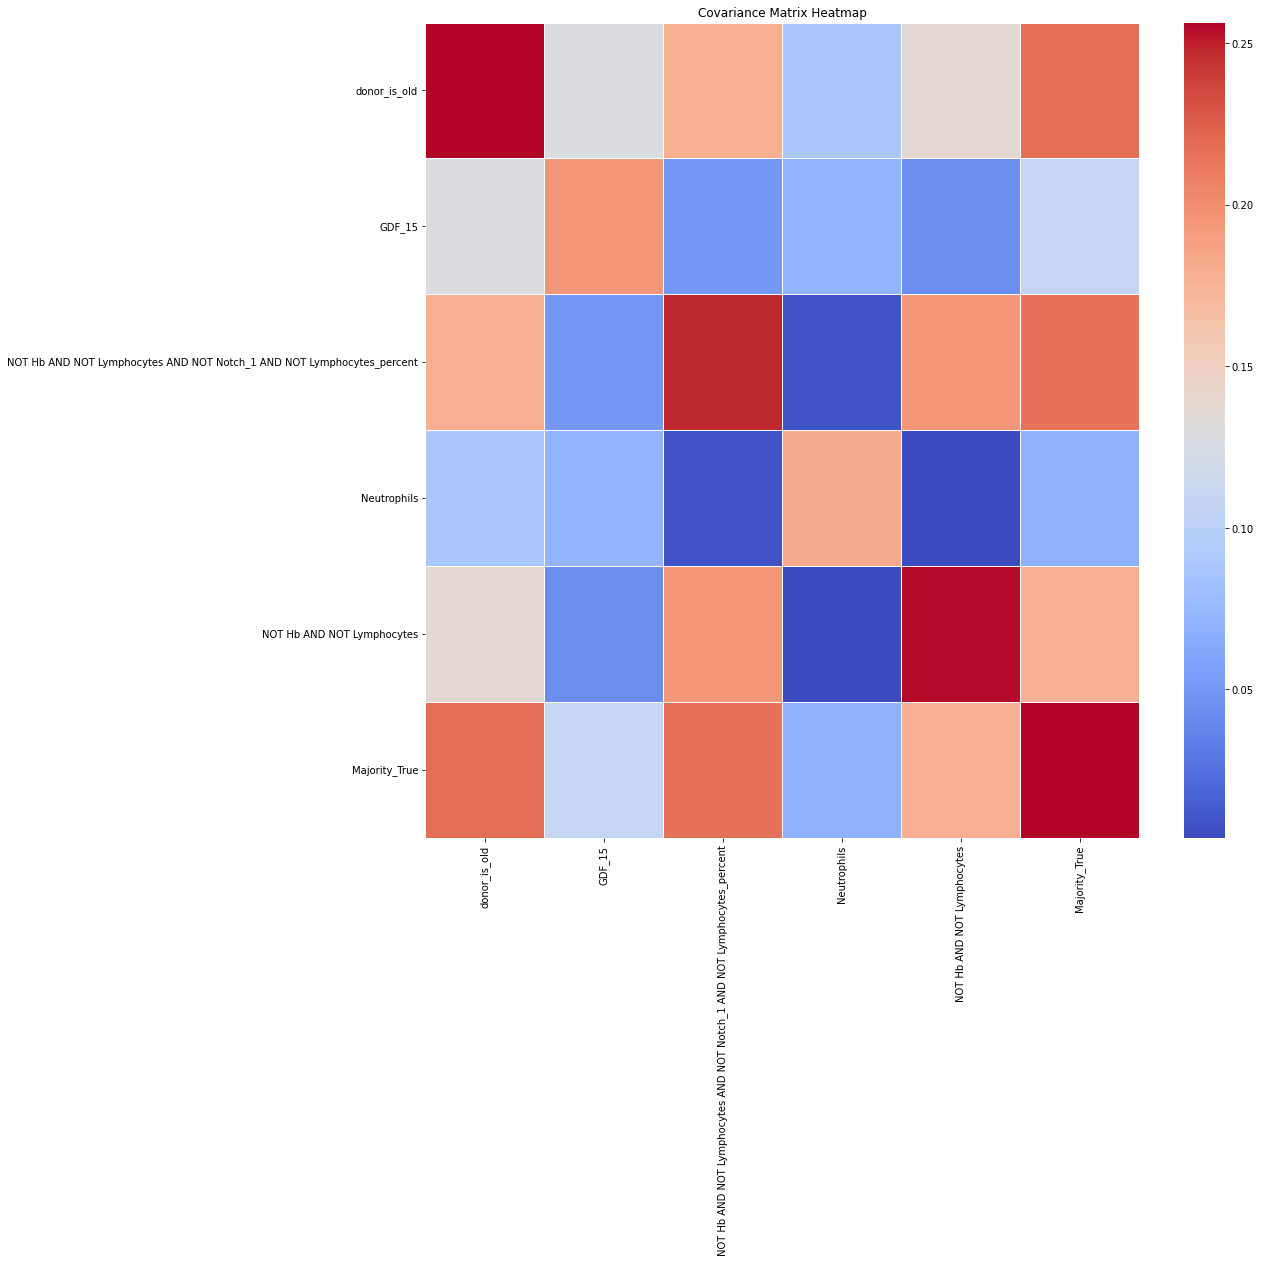

In [40]:
dfr = df_of_rules(df, [rule_to_dict(rule['rule']) for rule in final_ruleset]).drop('True_count', axis=1)

dfr_numeric = dfr.dropna()

dfr_numeric = dfr_numeric.astype(int)

rcov_matrix = dfr_numeric.cov()

plt.figure(figsize=(16, 15))
sns.heatmap(rcov_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Covariance Matrix Heatmap")
plt.show()

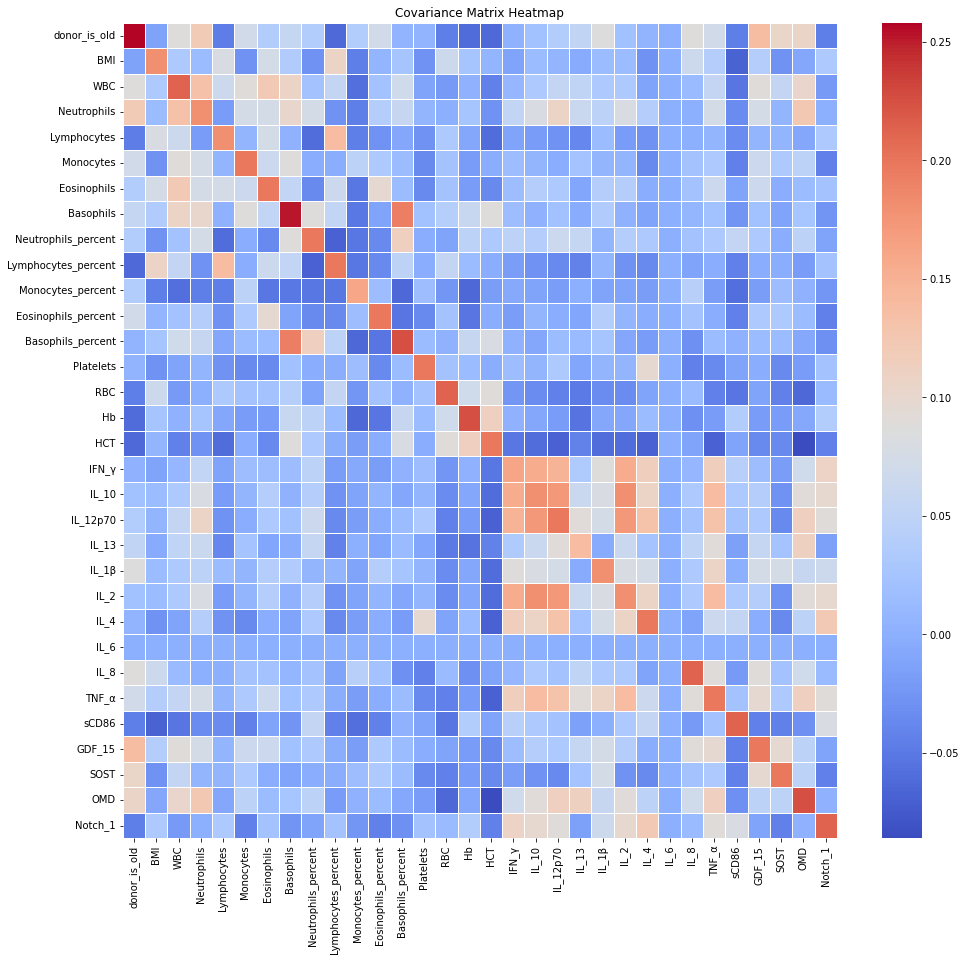

In [41]:
df_numeric = df.dropna()

df_numeric = df_numeric.astype(int)

cov_matrix = df_numeric.cov()

plt.figure(figsize=(16, 15))
sns.heatmap(cov_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Covariance Matrix Heatmap")
plt.show()

In [42]:
# # remove all rules that drop the auc
# k = 0
# ruleset = updated_rule_metrics
# prev_val = base_auc
# prev_cover = coverage(updated_rule_metrics)
# prev_acc = accuracy(updated_rule_metrics)

# while k < len(rule_metrics):
#     next_small = sorted(rule_metrics, key=lambda x: x['eval'])[k]
#     temp_ruleset = remove_elements(ruleset,
#                           [next_small['rule']])
#     curr_cover = coverage(temp_ruleset)
#     curr_AUC = auc_pr_calc(temp_ruleset)
#     curr_acc = accuracy(temp_ruleset)
#     if curr_AUC > prev_val and curr_cover >= prev_cover and curr_acc >= prev_acc:
#         ruleset = temp_ruleset
#     prev_cover = curr_cover
#     prev_val = curr_AUC
#     prev_acc = curr_acc
#     k += 1
# print(len(ruleset), auc_pr_calc(ruleset), coverage(ruleset), accuracy(ruleset))

In [43]:
# from sklearn.metrics import roc_auc_score, roc_curve

# TPR = np.array(recall_list)

# FPR = 1 - TPR * np.mean(precision_list)

# y_scores_flat = np.concatenate([precision_list, recall_list])
# y_true_flat = np.concatenate([np.ones_like(precision_list), np.zeros_like(recall_list)])

# roc_auc = roc_auc_score(y_true_flat, y_scores_flat)

# fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores_flat)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# print(f'ROC AUC score: {roc_auc:.4f}')

In [44]:
# # Convert rules into a list of transactions
# transactions = list(rule_dict.values())
# transactions

# # Encode transactions into a DataFrame
# te = TransactionEncoder()
# te_ary = te.fit(transactions).transform(transactions)
# df1 = pd.DataFrame(te_ary, columns=te.columns_)
# df1

# # Apply Apriori algorithm
# frequent_itemsets = apriori(df1, min_support=0.01, use_colnames=True)
# frequent_itemsets

# # Extract association rules
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
# rules

# # Display compressed rules
# print(rules[['antecedents', 'consequents', 'support', 'confidence']])